In [1]:
import seaborn as sns

import torch
from torch import nn
from torch import cuda

import pandas as pd
import numpy as np
import skimage
import os
import re
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from PIL import Image

# Making predictions
First, we need to download a pretrained model and change it according to transfer learning procedure we've use before<br><br>
Secod, we will set model parameters from a checkpoint.<br><br>
Third, we need some functions to process an input image.<br><br>
Finally, we can use our code to creat positive comments.

In [2]:
checkpoint_path = 'dataset/vgg16_transfer.pt'
model_name = 'vgg16'
n_classes = 20

In [3]:
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [4]:
def get_pretrained_model(model_name, **kwargs):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16, resnet50, inception_v3)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
    elif model_name == 'inception_v3':
        model = models.inception_v3(pretrained=True, aux_logits=False)
        
        for param in model.parameters():
            param.requires_grad = False
        
        model.fc = nn.Sequential(
                      nn.Linear(2048, n_classes),                  
                      nn.LogSoftmax(dim=1))
    
    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [5]:
checkpoint = torch.load(checkpoint_path)
model = get_pretrained_model(model_name)
model.load_state_dict(checkpoint)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
idx_class = [(0, 'Blazer'),
 (1, 'Blouse'),
 (2, 'Cardigan'),
 (3, 'Coat'),
 (4, 'Dress'),
 (5, 'Hoodie'),
 (6, 'Jacket'),
 (7, 'Jeans'),
 (8, 'Joggers'),
 (9, 'Jumpsuit'),
 (10, 'Kimono'),
 (11, 'Leggings'),
 (12, 'Romper'),
 (13, 'Shorts'),
 (14, 'Skirt'),
 (15, 'Sweater'),
 (16, 'Sweatpants'),
 (17, 'Tank'),
 (18, 'Tee'),
 (19, 'Top')]

In [7]:
model.class_to_idx = {
    class_: idx
    for idx, class_ in idx_class
}
model.idx_to_class = {
    idx: class_
    for idx, class_ in idx_class
}


In [8]:
IMG_SIZE = 224

In [9]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    
    # rescale such that smaller size equals 299
    width, height = image.size
    ratio = float(width) / height
    if ratio < 1:
        width = IMG_SIZE
        height = IMG_SIZE / ratio
    else:
        height = IMG_SIZE
        width = height * ratio
    img = image.resize((int(width), int(height)))

    # Center crop
    left = (width - IMG_SIZE) / 2
    top = (height - IMG_SIZE) / 2
    right = left + IMG_SIZE
    bottom = top + IMG_SIZE
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [10]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [11]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, IMG_SIZE, IMG_SIZE).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, IMG_SIZE, IMG_SIZE)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes

In [12]:
import random

def compliment(cloth_type):
    """
    Compliments clothes.

    Args:
        clothing_type: string, e.g. 'shirt'
    """
    
    templ_sg = [
        ("you've got a nice ", ""),
        ("your ", " is really beautiful!"),
        ("this ", " fits you very well!"),
        ("your ", " looks sooo cool!")
    ]
    templ_pl = [
        ("you've got nice ", ""),
        ("your ", " are really beautiful!"),
        ("these ", " fit you very well!"),
        ("your ", " look sooo cool!")
    ]
    plural = ['jeans', 'joggers', 'leggings', 'shorts', 'sweatpants']
    
    cloth_type = cloth_type.lower()
    i = random.randint(0, len(templ_sg) - 1)
    templ = templ_pl[i] if (cloth_type in plural) else templ_sg[i]
    comment = templ[0] + cloth_type + templ[1]
    
    return comment

In [29]:
def display_prediction(image_path, model, topk, true_class):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)
    
    res = [(ps[i], classes[i]) for i in range(len(ps))]
    res.sort(key=lambda x: x[0], reverse=True)
    
    compl = compliment(res[0][1])

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(true_class, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    ax.set_title('"' + compl + '"', size=20)
    plt.tight_layout()


In [30]:
moi_schi = process_image('dataset/IMG_20191224_025813.jpg')

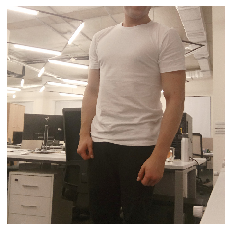

In [31]:
ax, img = imshow_tensor(moi_schi)

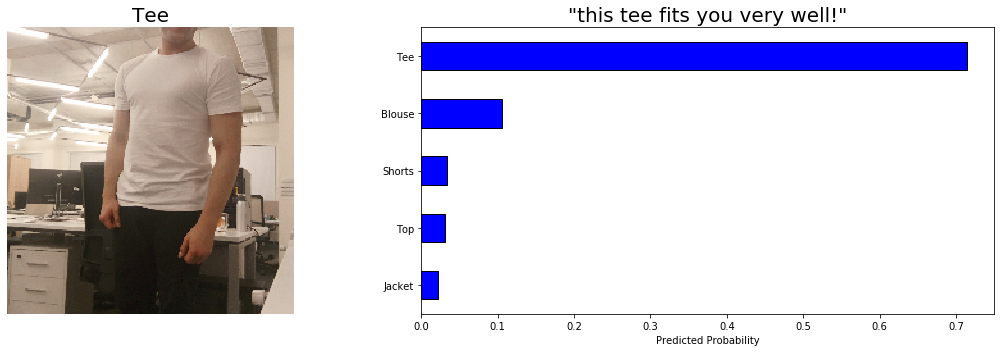

In [39]:
display_prediction('dataset/IMG_20191224_025813.jpg', model, topk=5, true_class='Tee')
plt.savefig('pred001.png', bbox_inches = 'tight')

In [40]:
moi_schi = process_image('dataset/IMG_20191224_040340.jpg')

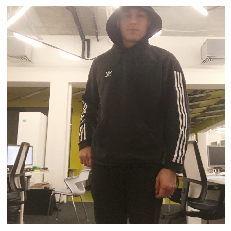

In [41]:
ax, img = imshow_tensor(moi_schi)

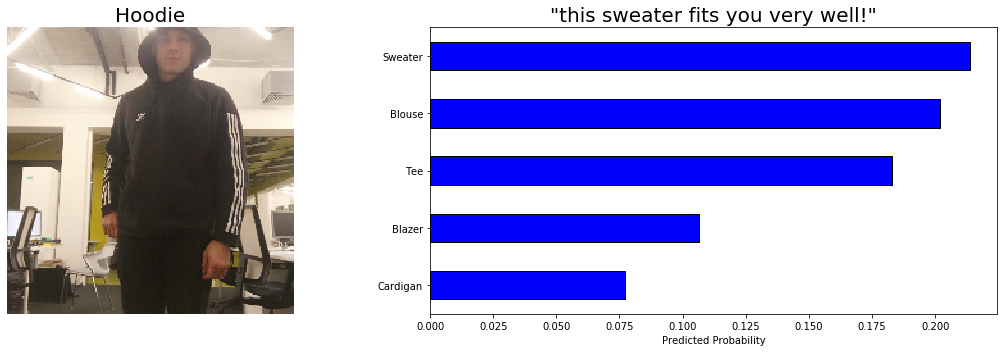

In [42]:
display_prediction('dataset/IMG_20191224_040340.jpg', model, topk=5, true_class='Hoodie')
plt.savefig('pred002.png', bbox_inches = 'tight')